# Skimage

Python possesses a powerful library for image analysis: [Skimage](http://scikit-image.org/). An image is represented as a Numpy array (2D for black and white and 3D for color images). Sklearn implements algorithms for all common manipulations of images: filtering, edge detection, transformations, texture detection...

We will give two small examples (mainly to show of the `interact` in IPython notebook).

More examples can be found on the main page.

## 1. Finding blobs

A basis form of image analysis is blob detection: finding regions in the image with different color, intensity... compared to the surroundings. This is often done to, for example, count cells in a microscopy image. Here we will use this to count galaxies in an image.

In [3]:
from matplotlib import pyplot as plt
from skimage import data  # Skimage contains a set of example images
from skimage.feature import blob_log
from skimage.color import rgb2gray
%matplotlib inline

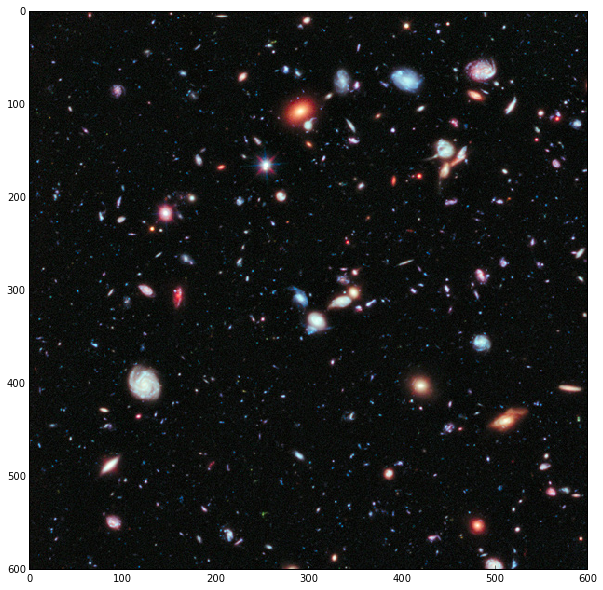

In [4]:
image = data.hubble_deep_field()[:600,:600]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image, interpolation='nearest')  # show image, just treat is as a matrix
image_gray = rgb2gray(image)  # set to grayscale for blob detection

We will use the Laplacian of Gaussian (Log) method to find the galaxies. This methods has threshold parameter that has to be tuned: the higher the beter the specificity but the lower the sensitivity.

First we will create a subroutine to perform the blob detection for a given threshold values:

In [5]:
def detect_blobs(threshold):
    blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=threshold)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title("Number of blobs")
    ax.imshow(image)
    for blob in blobs_log:
        y, x, r = blob
        c = plt.Circle((x, y), r, color="lime", linewidth=2, fill=False)
        ax.add_patch(c)
    print("Detected %i galaxies with a threshold of %s" %(len(blobs_log), threshold))

This function can be used to create a simple widget with a slider using the interact modele.

Detected 365 galaxies with a threshold of 0.21


<function __main__.detect_blobs>

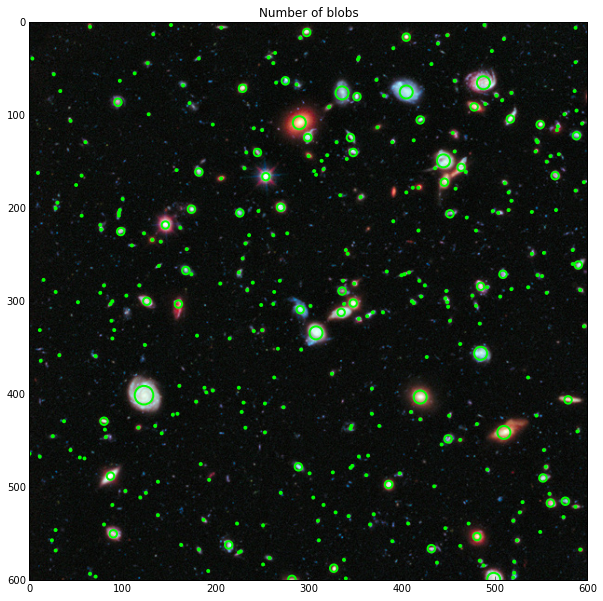

In [6]:
from IPython.html.widgets import interact

interact(detect_blobs, threshold=(0.01, 0.5, 0.05))

## 2. Segementation using clustering

Another common task in image analysis is segmentation, i.e. dividing the image into regions with similar propperties. This can be done using $k$-means clustering. 

In [7]:
from skimage.data import coffee
from sklearn.cluster import KMeans, MiniBatchKMeans
import numpy as np
coffee = coffee()

(400, 600, 3)


array([[[ 21,  13,   8],
        [ 21,  13,   9],
        [ 20,  11,   8],
        ..., 
        [228, 182, 138],
        [231, 185, 142],
        [228, 184, 140]],

       [[ 21,  13,   7],
        [ 21,  13,   9],
        [ 20,  14,   7],
        ..., 
        [228, 182, 136],
        [231, 185, 139],
        [229, 183, 137]],

       [[ 21,  14,   7],
        [ 23,  13,  10],
        [ 20,  14,   9],
        ..., 
        [228, 182, 136],
        [228, 184, 137],
        [229, 185, 138]],

       ..., 
       [[189, 124,  77],
        [214, 155, 109],
        [197, 141, 100],
        ..., 
        [165,  86,  37],
        [161,  82,  41],
        [143,  67,  29]],

       [[207, 148, 102],
        [201, 142,  99],
        [196, 140,  97],
        ..., 
        [154,  74,  37],
        [147,  66,  33],
        [145,  65,  31]],

       [[197, 141, 100],
        [195, 137,  99],
        [193, 138,  98],
        ..., 
        [158,  73,  38],
        [144,  64,  30],
        [143,  60,

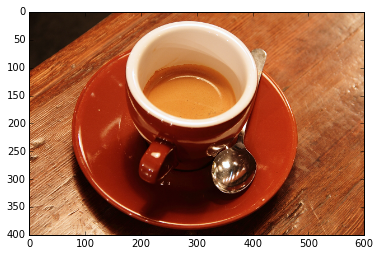

In [8]:
image_shape = coffee.shape
print(image_shape)
plt.imshow(coffee)
coffee

So our image is represented by a $400\times600\times3$ array. We can squeeze the image to a datamatrix where the observations (i.e. rows) correspond to the 240000 pixels and the three columns are the RGB values. Subsequently we use $k$-means clustering to find regions with similar color.

CPU times: user 17.2 s, sys: 1.79 s, total: 19 s
Wall time: 10.3 s


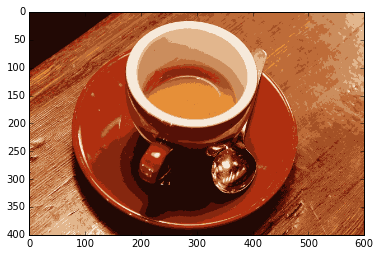

In [9]:
kmeans_clustering = KMeans(n_clusters=10)
%time cluster_kmeans = kmeans_clustering.fit_predict(coffee.reshape(-1, 3))
segm_image_km = kmeans_clustering.cluster_centers_[cluster_kmeans].reshape(image_shape)/255
plt.imshow(segm_image_km)

Nice! But segmentation takes quite long, as $k$-means is applied on a large dataset (240000 pixels!). Sklearn is equipped to deal with large datasets and often there exist algorithms which can be run on multiple processors. For $k$-means clustering there is an example which works by dividing the data into minibatches.

CPU times: user 802 ms, sys: 14.8 ms, total: 817 ms
Wall time: 434 ms


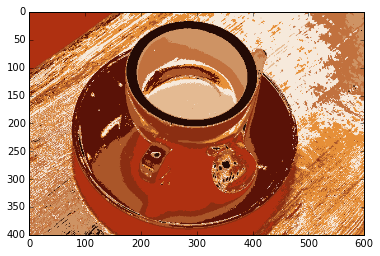

In [10]:
kmeans_clustering_minbatch = MiniBatchKMeans(n_clusters=10, batch_size=5000)
%time cluster_kmeans_minibatch = kmeans_clustering_minbatch.fit_predict(coffee.reshape(-1, 3))
segm_image_kmmb = kmeans_clustering_minbatch.cluster_centers_[cluster_kmeans].reshape(image_shape)/255
plt.imshow(segm_image_kmmb)

We see that the running time has decreased, but our outcome is rather crappy... 

CPU times: user 6.71 s, sys: 394 ms, total: 7.11 s
Wall time: 4.04 s


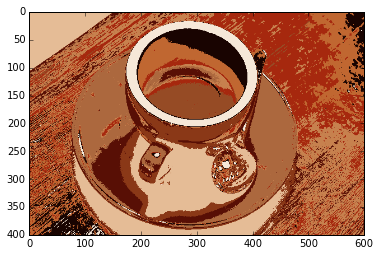

In [11]:
@interact
def mini_batch_km_segmentation(n_clusters=(3, 50, 1), batch_size=(100, 100000, 1000)):
    kmeans_clustering_minbatch = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size)
    %time cluster_kmeans_minibatch = kmeans_clustering_minbatch.fit_predict(coffee.reshape(-1, 3))
    segm_image_kmmb = kmeans_clustering_minbatch.cluster_centers_[cluster_kmeans].reshape(image_shape)/255
    plt.imshow(segm_image_kmmb)

# Biopython
[Biopython](http://biopython.org/wiki/Main_Page) contains everything you need for analysing bioinformatics data:
- parsing text-based bioinformatics files
- accessing the most important databases (Uniprot, Genbank, Kegg...)
- studying 3D protein structures
- phylogenetics
- ...

Two small examples to get you started.

## 1. Working with sequences

Biopython is equipped with parsers for most text-based bioinformatics databases.

In [12]:
from Bio import SeqIO
for item in SeqIO.parse("data/sweet_taste_receptor.txt", "fasta"):
    print(item)

ID: gi|20142332|gb|AF458154.1|AF458149S6
Name: gi|20142332|gb|AF458154.1|AF458149S6
Description: gi|20142332|gb|AF458154.1|AF458149S6 Homo sapiens taste-specific G-protein coupled receptor T1R2 (TAS1R2) gene, exon 6 and complete cds
Number of features: 0
Seq('GATGAATATGAATGCCAGGCCTGCCCGAATAACGAGTGGTCCTACCAGAGTGAG...TAG', SingleLetterAlphabet())


In [13]:
sequence = item.seq
sequence

Seq('GATGAATATGAATGCCAGGCCTGCCCGAATAACGAGTGGTCCTACCAGAGTGAG...TAG', SingleLetterAlphabet())

In [14]:
sequence.alphabet

SingleLetterAlphabet()

Let us see what we can do with one sequence:

In [15]:
sequence.reverse_complement()

Seq('CTAGTCCCTCCTCATGGTGTAGCCCTGGATCATGCTGTTGAAGTAGGCGGGCGT...ATC', SingleLetterAlphabet())

In [16]:
translated = sequence.translate()
translated

Seq('DEYECQACPNNEWSYQSETSCFKRQLVFLEWHEAPTIAVALLAALGFLSTLAIL...RD*', HasStopCodon(ExtendedIUPACProtein(), '*'))

Calculate isoelectric point:

In [17]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [18]:
protein_analyser = ProteinAnalysis(str(translated))
print(protein_analyser.isoelectric_point())

8.52288818359


## 2. Reading multiple sequence alignments

In [19]:
from Bio import AlignIO
from Bio.Align import AlignInfo
from collections import Counter
import pandas as pd

In [20]:
alignment = AlignIO.read("data/muscle_cons_refs.txt", "clustal")
alignment.sort()
print(alignment)

SingleLetterAlphabet() alignment with 90 rows and 351 columns
--MKFSAPLALASLAAAAAAATPVP------------KRATVDF...--- consensus
--MKFSLSVALSLAAATAQAAT--------------------QF...--- gi|119496835|ref|XP_001265191.1|
--MKFNLALALSLTVATAEAAT--------------------EL...--- gi|121702845|ref|XP_001269687.1|
--MKVLALSALLSLASAASIS----------------RRS--DF...--- gi|145228915|ref|XP_001388766.1|
MNRYLSIPLCLASAVPALAGLAA--------------RDPIGTI...--- gi|145235569|ref|XP_001390433.1|
--MKFTQSLVSLVLATVAVANPTPTLE----------ERAAVTK...--- gi|154322503|ref|XP_001560566.1|
--MKFTQSLVSLALATVAVASPTAIVD----------KRA--TT...--- gi|156064981|ref|XP_001598412.1|
--MKLTL-FTLASVTALAVAAPAPQVIETLE------KRA--DY...--- gi|169598322|ref|XP_001792584.1|
--MKFLTPLVLSSLASAAALN----------------RRA--DM...--- gi|169771109|ref|XP_001820024.1|
--MKYSALLIASTASLALAAPATTVQ-----------KRA--DF...--- gi|189208482|ref|XP_001940574.1|
--MKSFAPLSLLSLALVGLSNAATIPTKSLT------RRA--DF...--- gi|195610100|gb|ACG26880.1|
--MTYLISLGLAGLALAASSGSCDLS-----------KRA--

We can calculate a quick concensus sequence:

In [21]:
align_summary = AlignInfo.SummaryInfo(alignment)
print(align_summary.dumb_consensus(threshold=0.3))

MMMKFSAXLALASLAXAAAAXATPXXXXXXXXXQPLSXRATVDFXCGQWDSXTTXGXYTXYNNLWGXXTXATSGSHQCTGVDSLVNDSGNGTIAWHTSWSWAGEGSGQVKSYANAALXXPGTFTPKQLSSISSIPSTWKWSYSYSHGTSNIVADVAYDLFTSSSTASNSDGSXHEYEIMIWLAALGGAGPISSTYGSXXXXTPIATPTIAGVSWAGYSGKLYKGPNGQMTVYSFVAXSTVTSXFSGDLXDFFTYLVXNQGLPSSQYLTSVQAGTEPFTGSNTAKFTTSAYSVSVXTXXXXXXXXXXXPXXPXXXAXXXXXXGXXXXXXXXXXXXXXXXXXXXXXQXXSQCS


In [22]:
AA_freq_pos = []
n = alignment.get_alignment_length()

for i in range(n):
    if alignment[0,i] is not '-':
        AA_freq_pos.append(Counter(alignment[1:,i]))

AA_table = pd.DataFrame(AA_freq_pos).T
AA_table = AA_table.fillna(0)  # remove NA
AA_table = AA_table[1:]  # remove empty char

In [23]:
AA_table /= AA_table.sum()
AA_table

,0,1,2,3,4,5,6,7,8,9,...,253,254,255,256,257,258,259,260,261,262
A,0.012048,0.035294,0.011765,0.129412,0.313953,0.098765,0.093023,0.325581,0.186047,0.395349,...,0.000000,0.000000,0.011364,0.318182,0.000000,0.000000,0.193182,0.215909,0.000000,0.162791
C,0.000000,0.000000,0.000000,0.000000,0.011628,0.000000,0.000000,0.034884,0.023256,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.011364,0.000000,0.000000,0.000000,0.000000
D,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.011628,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.022727,0.000000,0.046512
E,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.045455,0.056818,0.104651
F,0.012048,0.011765,0.411765,0.117647,0.000000,0.098765,0.023256,0.058140,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.113636,0.000000,0.011364,0.000000,0.034091,0.000000
G,0.048193,0.000000,0.011765,0.011765,0.058140,0.000000,0.011628,0.023256,0.000000,0.023256,...,0.000000,0.000000,0.000000,0.056818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
H,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.000000,0.000000
I,0.012048,0.000000,0.000000,0.082353,0.093023,0.061728,0.069767,0.046512,0.023256,0.023256,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.170455,0.011364,0.147727,0.000000
K,0.084337,0.647059,0.023529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.104651,0.000000,0.000000,0.022727,0.000000,0.022727,0.000000,0.011364,0.000000,0.034884
L,0.048193,0.023529,0.294118,0.200000,0.127907,0.074074,0.523256,0.069767,0.488372,0.244186,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.193182,0.046512


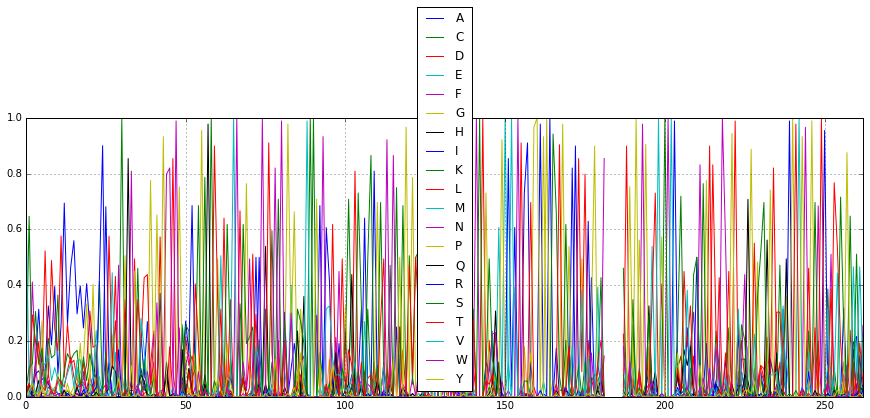

In [24]:
AA_table.T.plot(figsize=(15, 5))